This notebook was made to predict the likelihood of students from portugal failing their maths test based on a number of relevant features

1. Import Libraries

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns

2. Load data, in this notebook we will look at maths performance

In [12]:
import pandas as pd

df = pd.read_csv("student-mat.csv")

df.head()

,school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3
0,"GP;""F"";18;""U"";""GT3"";""A"";4;4;""at_home"";""teacher..."
1,"GP;""F"";17;""U"";""GT3"";""T"";1;1;""at_home"";""other"";..."
2,"GP;""F"";15;""U"";""LE3"";""T"";1;1;""at_home"";""other"";..."
3,"GP;""F"";15;""U"";""GT3"";""T"";4;2;""health"";""services..."
4,"GP;""F"";16;""U"";""GT3"";""T"";3;3;""other"";""other"";""h..."


3. Clean data, only keeping the columns that seem relevant

In [13]:
# Adding a delimiter allows us to separate the columns correctly
df = pd.read_csv("student-mat.csv", delimiter=';')

# The relevant columns
columns_to_keep = [
    'famsup', 'schoolsup', 'studytime', 'activities',
    'absences', 'internet', 'Fedu', 'Medu', 'failures', 'goout', 'age'
]

# G1-3 (the grades) are excluded as students who score high are guaranteed to pass

df = df[columns_to_keep]

# Convert yes/no columns to binary 1/0
binary_cols = ['famsup', 'schoolsup', 'activities', 'internet']
df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == 'yes' else 0)

# View new dataframe
df.head()


C:\Users\arifu\AppData\Local\Temp\ipykernel_10500\1197850780.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == 'yes' else 0)


,famsup,schoolsup,studytime,activities,absences,internet,Fedu,Medu,failures,goout,age
0,0,1,2,0,6,0,4,4,0,4,18
1,1,0,2,0,4,1,1,1,0,3,17
2,0,1,2,0,10,1,1,1,3,2,15
3,1,0,3,1,2,1,2,4,0,2,15
4,1,0,2,0,4,0,3,3,0,2,16


4. Prepare the target variable and features for training the model

In [14]:

features = ['famsup', 'schoolsup', 'studytime', 'activities',
    'absences', 'internet', 'Fedu', 'Medu', 'goout', 'age']
X = df[features]


# For better visibility we will only test for the chance of failing once, deeming failure
# Also, there are very few students who failed more than once so this simplifies the model
df['failed'] = df['failures'].apply(lambda x: 1 if x > 0 else 0)
y = df['failed']


5. Applying this to a random forest model

In [15]:

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.98      0.92        65
           1       0.80      0.29      0.42        14

    accuracy                           0.86        79
   macro avg       0.83      0.64      0.67        79
weighted avg       0.85      0.86      0.83        79



From here we can see that the model has very high precision in predicting passes, and it gets them correct. However, it hardly picks up on any failures which has lead to a low f1-score.

This may be because there are not much samples available which limits the accuracy of the model, there is also a small class imbalance in the dataset leaving the model to be more cautious in picking up failures.

This means we may use SMOTE to balance the dataset and prevent the model from being bias towards the majority class.

My last attempt at using it for the credit card notebook I did didn't go to well, so this time I will also add GridSearchCV, so we can see which hyperparameters are the best for the random forest.

6. Retrain model applying SMOTE and GridSearchCV

In [22]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

# Pipeline with SMOTE and RandomForest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Parameter grid for GridSearch
param_grid = {
    'rf__n_estimators': [50, 100, 200, 300, 400],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 7],
    'rf__class_weight': [None]  # The model will not hold favour on any class
}

# Recall is used as scoring to improve failure detection
grid = GridSearchCV(pipeline, param_grid, scoring='recall', cv=5)
# 5 fold cross-val to train and test 5 times
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

# Predict on test set
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))


Best parameters: {'rf__class_weight': None, 'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.84      0.89      0.87        47
           1       0.50      0.38      0.43        13

    accuracy                           0.78        60
   macro avg       0.67      0.64      0.65        60
weighted avg       0.77      0.78      0.77        60



Using SMOTE and GridSearchCV has shown some improvement in predicting the number of failures, while the model predicts more incorrectly, it does predict failures more often. This is understandable because with SMOTE the model can predict more failures due to the synthetic values but this leads to a drop in precision since the real data is has very few failures. Overall, applying SMOTE has given the effects that were expected but it hasn't really improved the effectiveness of the model. Further improvements to this could be to include the G1 scores and see if the model is better at predicting failure, as it will not make use of G2-3. 

 It seems the model works best at 300 trees and doesn't have a max depth so the trees continue to grow showing a deep level of processing. The tree also has a high number of samples in each node, this makes it better at generalising as there will be less 'case-by-case' testing and it will process them faster.



7. Feature importance

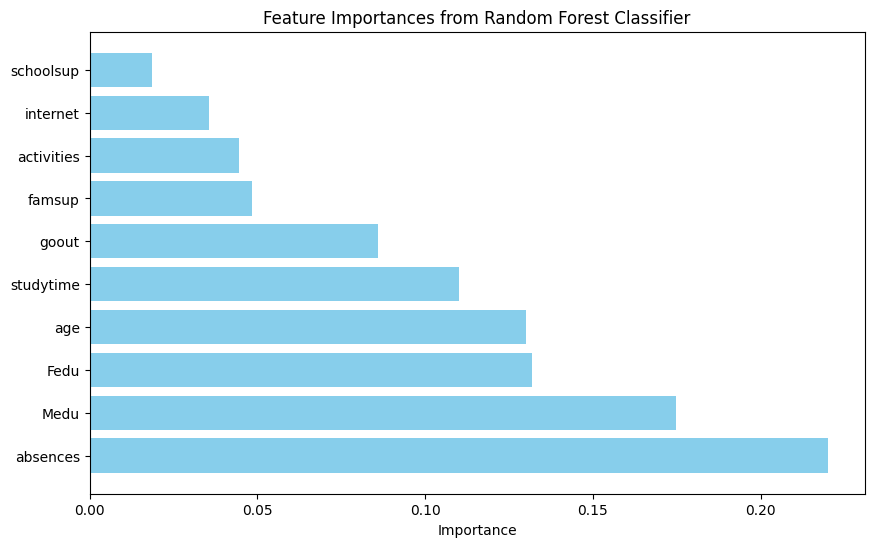

In [17]:

# Get feature importances from the best model
importances = grid.best_estimator_.named_steps['rf'].feature_importances_
# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest Classifier')
plt.show() 

As expected, absences are the most important factor in determining failure, students who don't come to school are more likely to fail. Surprisingly, the mother's education also comes into effect but this may be due to the context of the data. It is less likely for women in Portugal to attend higher education and women that do will naturally have children that have advantages such as attitudes towards education, financial benefits or education opportunities in general.

8. Some EDA can be made to give explore studying in more detail

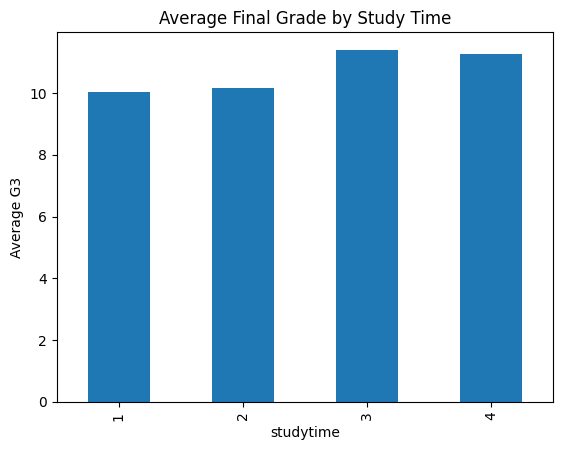

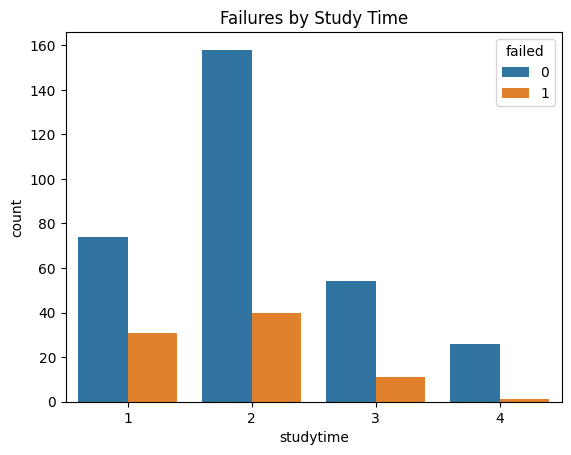

In [21]:
df_G3 = pd.read_csv("student-mat.csv")
df_G3 = pd.read_csv("student-mat.csv", delimiter=';')

# Bar chart of final grade by study time
df_G3.groupby('studytime')['G3'].mean().plot(kind='bar')
plt.ylabel('Average G3')
plt.title('Average Final Grade by Study Time')
plt.show()

# Bar chart of the hours of study and how many students failed
sns.countplot(x='studytime', hue='failed', data=df)
plt.title('Failures by Study Time')
plt.show()


From both graphs, we can see that studying more will definitely increase the likelihood of avoiding failure and getting a high score. But combined with the feature importance it is not the the most important factor in determining a student's grade, other factors must also be met for a student to do well, namely attending school.